# Model Preprocessing Notebook

## Goal: replace corners of images and combine annotation masks for model preprocessing
Input: all images, multi-layer annotation masks

Output: all images with replaced corners, combined annotation mask

## Basic Setup
1. Import dependencies

In [2]:
import os
os.getcwd()

'/Users/sophiacofone/school_local/svi_worm_anno/annot/bact_mask'

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import tifffile
import sys
import os
import re

In [4]:
from skimage.measure import block_reduce

In [5]:
# get relevant file paths for annotation masks
mask_path_1 = "round1"
mask_path_2 = "round2"


proj_path_1 = "round1"
proj_path_2 = "round2"

## Corner replacement
Removes the neighboring worms from the images

In [7]:
# create list of dicts where each entry corresponds to a single mask
# inputs are mask directory and filename, raw data filename and dir
# mask number is the worm within the raw data file

def parse_mask_dir(m_directory,r_dir):
    files = os.listdir(m_directory)

    # The list to store the dictionaries
    file_dicts = []

    for file in files:
        # Check if the file name contains "mask_"
        if "mask_" in file:
            # Get the part of the file name before "mask_"
            raw_file = file.split("mask_")[0] + ".tiff"

            # Extract the number after "mask_" using regex
            mask_num = re.search("mask_(\d+)", file)
            if mask_num is not None:
                mask_num = int(mask_num.group(1))
            else:
                mask_num = None

            # Create the dictionary
            file_dict = {
                "mask_file": file,
                "mask_dir": m_directory,
                "raw_file": raw_file,
                "raw_dir": r_dir,
                "mask_num": mask_num,
            }

            # Add the dictionary to the list
            file_dicts.append(file_dict)
    return file_dicts

mask_dict_1 = parse_mask_dir(mask_path_1,proj_path_1)
mask_dict_2 = parse_mask_dir(mask_path_2,proj_path_2)
mask_dict_1[0]

{'mask_file': 'wspa_6_6_23_wspa_dn_proj_tstack_dev1_pos_0_mask_6.tiff',
 'mask_dir': 'round1',
 'raw_file': 'wspa_6_6_23_wspa_dn_proj_tstack_dev1_pos_0_.tiff',
 'raw_dir': 'round1',
 'mask_num': 6}

In [8]:
def find_dictionary(lst):
    for index, entry in enumerate(lst):
        if 'raw_file' in entry and 'mask_num' in entry:
            if entry['raw_file'] == 'wspa_6_6_23_wspa_dn_proj_tstack_dev1_pos_0_.tiff' and entry['mask_num'] == 11:
                return index, entry
    return None

d_idx,d = find_dictionary(mask_dict_1)
d_idx,d

(35,
 {'mask_file': 'wspa_6_6_23_wspa_dn_proj_tstack_dev1_pos_0_mask_11.tiff',
  'mask_dir': 'round1',
  'raw_file': 'wspa_6_6_23_wspa_dn_proj_tstack_dev1_pos_0_.tiff',
  'raw_dir': 'round1',
  'mask_num': 11})

In [9]:
r = tifffile.imread(os.path.join(d['raw_dir'],d['raw_file']))[0,...]

In [10]:
r.shape

(3, 2048, 2048)

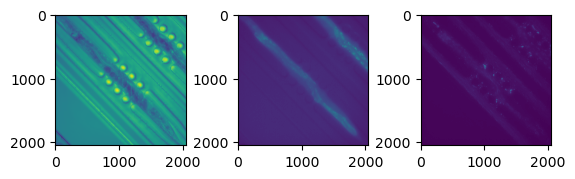

In [11]:
# get image stack with end worm 
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.subplots_adjust(wspace=0.4)
    plt.imshow(r[i,...])

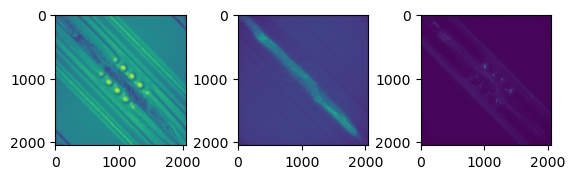

In [12]:
# copy the end worm stack
# duplicate the bottom corrner to the top (mirror/replace), this gets rid of the neighboring worms
r_copy = r.copy()

triangle_size = 450
for cc in range(r_copy.shape[0]):
    for i in range(2048):
        for j in range(2048):
            # Replace the pixels of the upper right triangle with the ones from the lower left triangle
            if j > i+triangle_size:
                r_copy[cc,i,j] = r_copy[cc,2047-i,2047-j]

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.subplots_adjust(wspace=0.4)
    plt.imshow(r_copy[i,...])

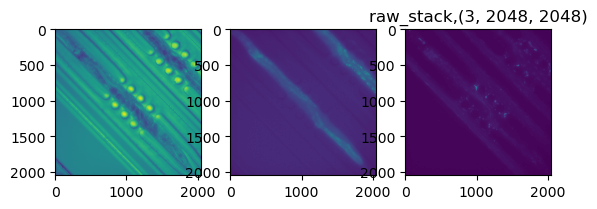

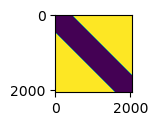

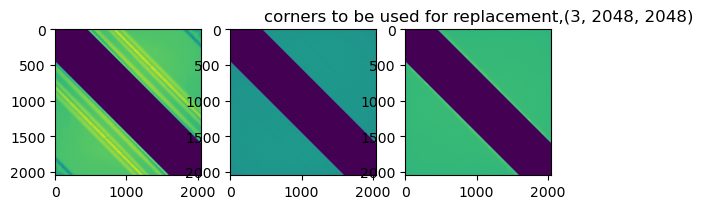

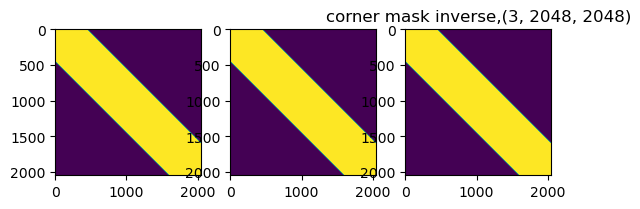

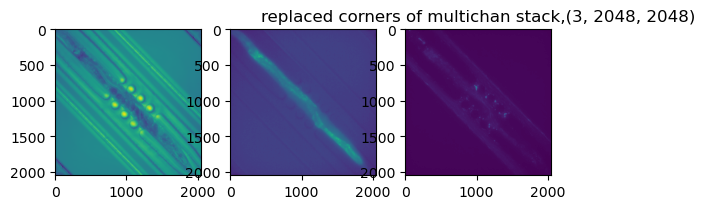

In [13]:
# go through the dict of masks, open the mask stack, open corresponding worm stack
# for worm stack replace the corrners
plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(r[i,...])
plt.title('raw_stack,{}'.format(r.shape))

    
    
triangle_size = 450
cor_mask = np.zeros((2048,2048))
for i in range(cor_mask.shape[0]):
    for j in range(cor_mask.shape[1]):
        if j > i+triangle_size or i>j+triangle_size:
            cor_mask[i,j] = 1
plt.figure(figsize = [1,1])
plt.imshow(cor_mask)
expanded_mask = np.expand_dims(cor_mask, axis=0)

r_corners = r_copy * expanded_mask

plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(r_corners[i,...])
plt.title('corners to be used for replacement,{}'.format(r_corners.shape))

    
annot_crop_tools_path = r"C:\Users\LevineLab\Documents\tensorflow_notebooks\soph_crop_tools"
os.makedirs(annot_crop_tools_path,exist_ok = True)

np.save(os.path.join(annot_crop_tools_path,'cor_replace_multichan_450'),r_corners)


cor_mask_i = np.ones((3,2048,2048)) -expanded_mask
np.save(os.path.join(annot_crop_tools_path,'cor_mask_multichan_inv_450'),cor_mask_i)

plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(cor_mask_i[i,...])
plt.title('corner mask inverse,{}'.format(cor_mask_i.shape))
    

r_replaced = r*cor_mask_i+r_corners

plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(r_replaced[i,...])
plt.title('replaced corners of multichan stack,{}'.format(r_replaced.shape));


## Combine annotation bateria masks into single binary output

In [19]:
# for the mask stack combine the 2 masks into 1 mask
# when we muliply the binary mask by the red (or green) channel, we will get an image back of just the red and we can sum the pixel values
# assumpotion is at pixel locations where there is green bacteria in the gut, the respective red channel at that pixel will correspond to either red bac in gut or no florecence at all
# in the former good, in the latter is ok b/c multiplying 1*0 is 0.
# even if non 0, value very low and removed in background subtraction phase
annot_crop_tools_path = 'tools'


cor_mask_i = np.load(os.path.join(annot_crop_tools_path,'cor_mask_multichan_inv_450.npy'))
cor_replace = np.load(os.path.join(annot_crop_tools_path,'cor_replace_multichan_450.npy'))

def replace_cor(image,cor_replace = cor_replace,cor_mask_i = cor_mask_i):
    return image*cor_mask_i+cor_replace

def min_pool(img, pool_size):
    return block_reduce(img, block_size=(pool_size, pool_size), func=np.min)

def med_pool(img, pool_size):
    return block_reduce(img, block_size=(pool_size, pool_size), func=np.median)

def min_pool_stack(stack, pool_size):
    return block_reduce(stack, block_size=(1, pool_size, pool_size), func=np.min)

def med_pool_stack(stack, pool_size):
    return block_reduce(stack, block_size=(1, pool_size, pool_size), func=np.median)


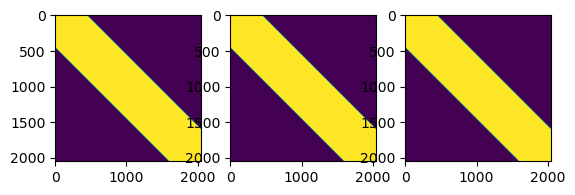

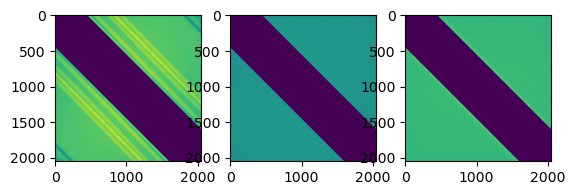

In [20]:
plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(cor_mask_i[i,...])
plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(cor_replace[i,...])

In [25]:
for d in mask_dict_1[4:5]:
    m = tifffile.imread(os.path.join(d['mask_dir'],d['mask_file']))
    r = tifffile.imread(os.path.join(d['raw_dir'],d['raw_file']))[d['mask_num'],...]
    
    m1_pool = min_pool(np.max(m,axis = 0),2)
    expanded_m1_pool = np.expand_dims(m1_pool, axis=0)
    r_replaced_pool = med_pool_stack(replace_cor(r),2)

    combined_set = np.concatenate((r_replaced_pool, expanded_m1_pool), axis=0)
    
print(m.shape)
print(m1_pool.shape)
print(r.shape)
print(r_replaced_pool.shape)
print(combined_set.shape)

(2, 2048, 2048)
(1024, 1024)
(3, 2048, 2048)
(3, 1024, 1024)
(4, 1024, 1024)


Text(0.5, 1.0, 'cropped_pooled_annot_combined_stack,(4, 1024, 1024)')

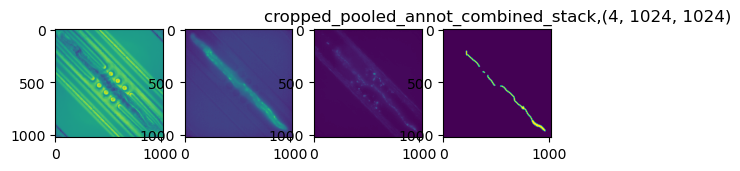

In [26]:
plt.figure()
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(combined_set[i,...])
plt.title('cropped_pooled_annot_combined_stack,{}'.format(combined_set.shape))

In [28]:
save_data_set_path = 'output'
os.makedirs('output',exists_ok=True)

for ff,d in enumerate(mask_dict_1):
    m = tifffile.imread(os.path.join(d['mask_dir'],d['mask_file']))
    r = tifffile.imread(os.path.join(d['raw_dir'],d['raw_file']))[d['mask_num'],...]
    
    m1_pool = min_pool(np.max(m,axis = 0),2)
    expanded_m1_pool = np.expand_dims(m1_pool, axis=0)
    r_replaced_pool = med_pool_stack(replace_cor(r),2)

    combined_set = np.concatenate((r_replaced_pool, expanded_m1_pool), axis=0)
    
    tifffile.imwrite(os.path.join(save_data_set_path,f'wstack_annot_{ff}.tiff'),combined_set)


In [29]:
import json
file_path = os.path.join(save_data_set_path, 'file_sources_dict_wstack_anot.json')

with open(file_path, 'w') as json_file:
    json.dump(mask_dict_1, json_file)